In [1]:
import math
import os
import gc
import sys
import time

from functools import partial
from typing import Callable, Dict, Iterator, List, Optional, Tuple, Union

from tqdm.notebook import tqdm

In [2]:
BASE_DIR = '/home/dmitry/projects/dfdc'
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')
HDF5_DIR = '/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5'

In [3]:
import cv2
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import Tensor

In [4]:
# src
sys.path.insert(0, os.path.join(BASE_DIR, 'src'))
from dataset.utils import read_labels
from prepare_data import get_file_list

In [5]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [6]:
def space_frames_evenly(n: int, total: int) -> np.ndarray:
    idxs = np.linspace(0, total, min(n, total), dtype=int, endpoint=False)
    rnd_shift = np.random.randint(0, (total - idxs[-1]))
    return idxs + rnd_shift


def rnd_conseq_frames(n: int, total: int) -> np.ndarray:
    idxs = np.arange(0, min(n, total))
    rnd_shift = np.random.randint(0, (total - idxs[-1]))
    return idxs + rnd_shift


def create_mask(idxs: np.ndarray, total: int) -> np.ndarray:
    mask = np.zeros(total, dtype=np.bool)
    mask[idxs] = 1
    return mask


def check_len_hdf5(path):
    lens = dict()
    for name in os.listdir(path):
        full_path = os.path.join(path, name)
        if os.path.isfile(full_path):
            with h5py.File(full_path, 'r+') as f:
                lens[name] = len(f)
    return lens

In [7]:
# path = '/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_17/'
# path += 'rbfvimgnid.h5'
# num_frames = 10
# sample_fn = partial(space_frames_evenly, num_frames)
# cols = math.ceil(num_frames / 6)
# faces = read_hdf5(path, num_frames=num_frames, sample_fn=sample_fn)        
# show_images(faces, cols=cols)

In [8]:
# check_len_hdf5('/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_26')

In [9]:
def find_num_frames(df, idxs):
    lens = []
    for idx in idxs:
        meta = df.iloc[idx]
        path = os.path.join(HDF5_DIR, meta.dir, meta.name[:-4]+'.h5')
        if os.path.isfile(path):
            with h5py.File(path, 'r+') as f:
                lens.append(len(f))
        else:
            lens.append(-1)
    return lens

In [10]:
def read_hdf5(path: str, num_frames: int, size: int,
              sample_fn: Callable[[int], np.ndarray]) -> np.ndarray:
    img_size = (size, size)
    images = []
    with h5py.File(path, 'r+') as file:
        total_frames = len(file)
        idxs = sample_fn(total_frames)
        pick = create_mask(idxs, total_frames)
        for i, key in enumerate(file.keys()):
            if pick[i]:
                img = np.uint8(file[key])
                img = cv2.imdecode(img, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size, interpolation=cv2.INTER_NEAREST)
                images.append(img)
    return np.stack(images)


def sample_batch(
        video_idxs: np.ndarray, df: pd.DataFrame, 
        num_frames=15, pad='start', size=224, 
        data_dir=HDF5_DIR) -> Tuple[Iterator[List[np.ndarray]], int, np.ndarray]:
    img_size = (size, size)
    pad_dim = 0 if pad == 'start' else 1
    labels = np.zeros(len(idxs), np.uint8)
    videos = []
    
    for i, video_idx in enumerate(video_idxs):
        meta = df.iloc[video_idx]
        path = os.path.join(data_dir, meta.dir, meta.name[:-4]+'.h5')
        
        if os.path.isfile(path):
            dice = np.random.rand()
            sample_fn = space_frames_evenly if dice > 0.4 else rnd_conseq_frames
            video = read_hdf5(path, num_frames, size, 
                              sample_fn=partial(sample_fn, num_frames))
        else:
            print('Bad path: {}'.format(path))
            video = np.zeros((num_frames, size, size, 3), dtype=np.uint8)

        num_miss_frames = num_frames - len(video)
        if num_miss_frames > 0:
            dims = np.zeros((video.ndim, 2), dtype=np.int8)
            dims[0, pad_dim] = num_miss_frames
            video = np.pad(video, dims, 'constant')
        videos.append(video)
        labels[i] = meta.label

    return np.stack(videos), labels

In [11]:
df = read_labels(DATA_DIR, ['dfdc_train_part_26'])

In [12]:
idxs = np.uint16(list(range(0, 100, 15)))
idxs

array([ 0, 15, 30, 45, 60, 75, 90], dtype=uint16)

In [13]:
find_num_frames(df, idxs)

[43, 60, 18, 30, 30, 27, 30]

In [14]:
samples, labels = sample_batch(idxs, df, num_frames=30, size=224, pad='start')
samples.shape, labels

((7, 30, 224, 224, 3), array([1, 1, 1, 1, 1, 1, 1], dtype=uint8))

In [15]:
i = 0

Frame: 0


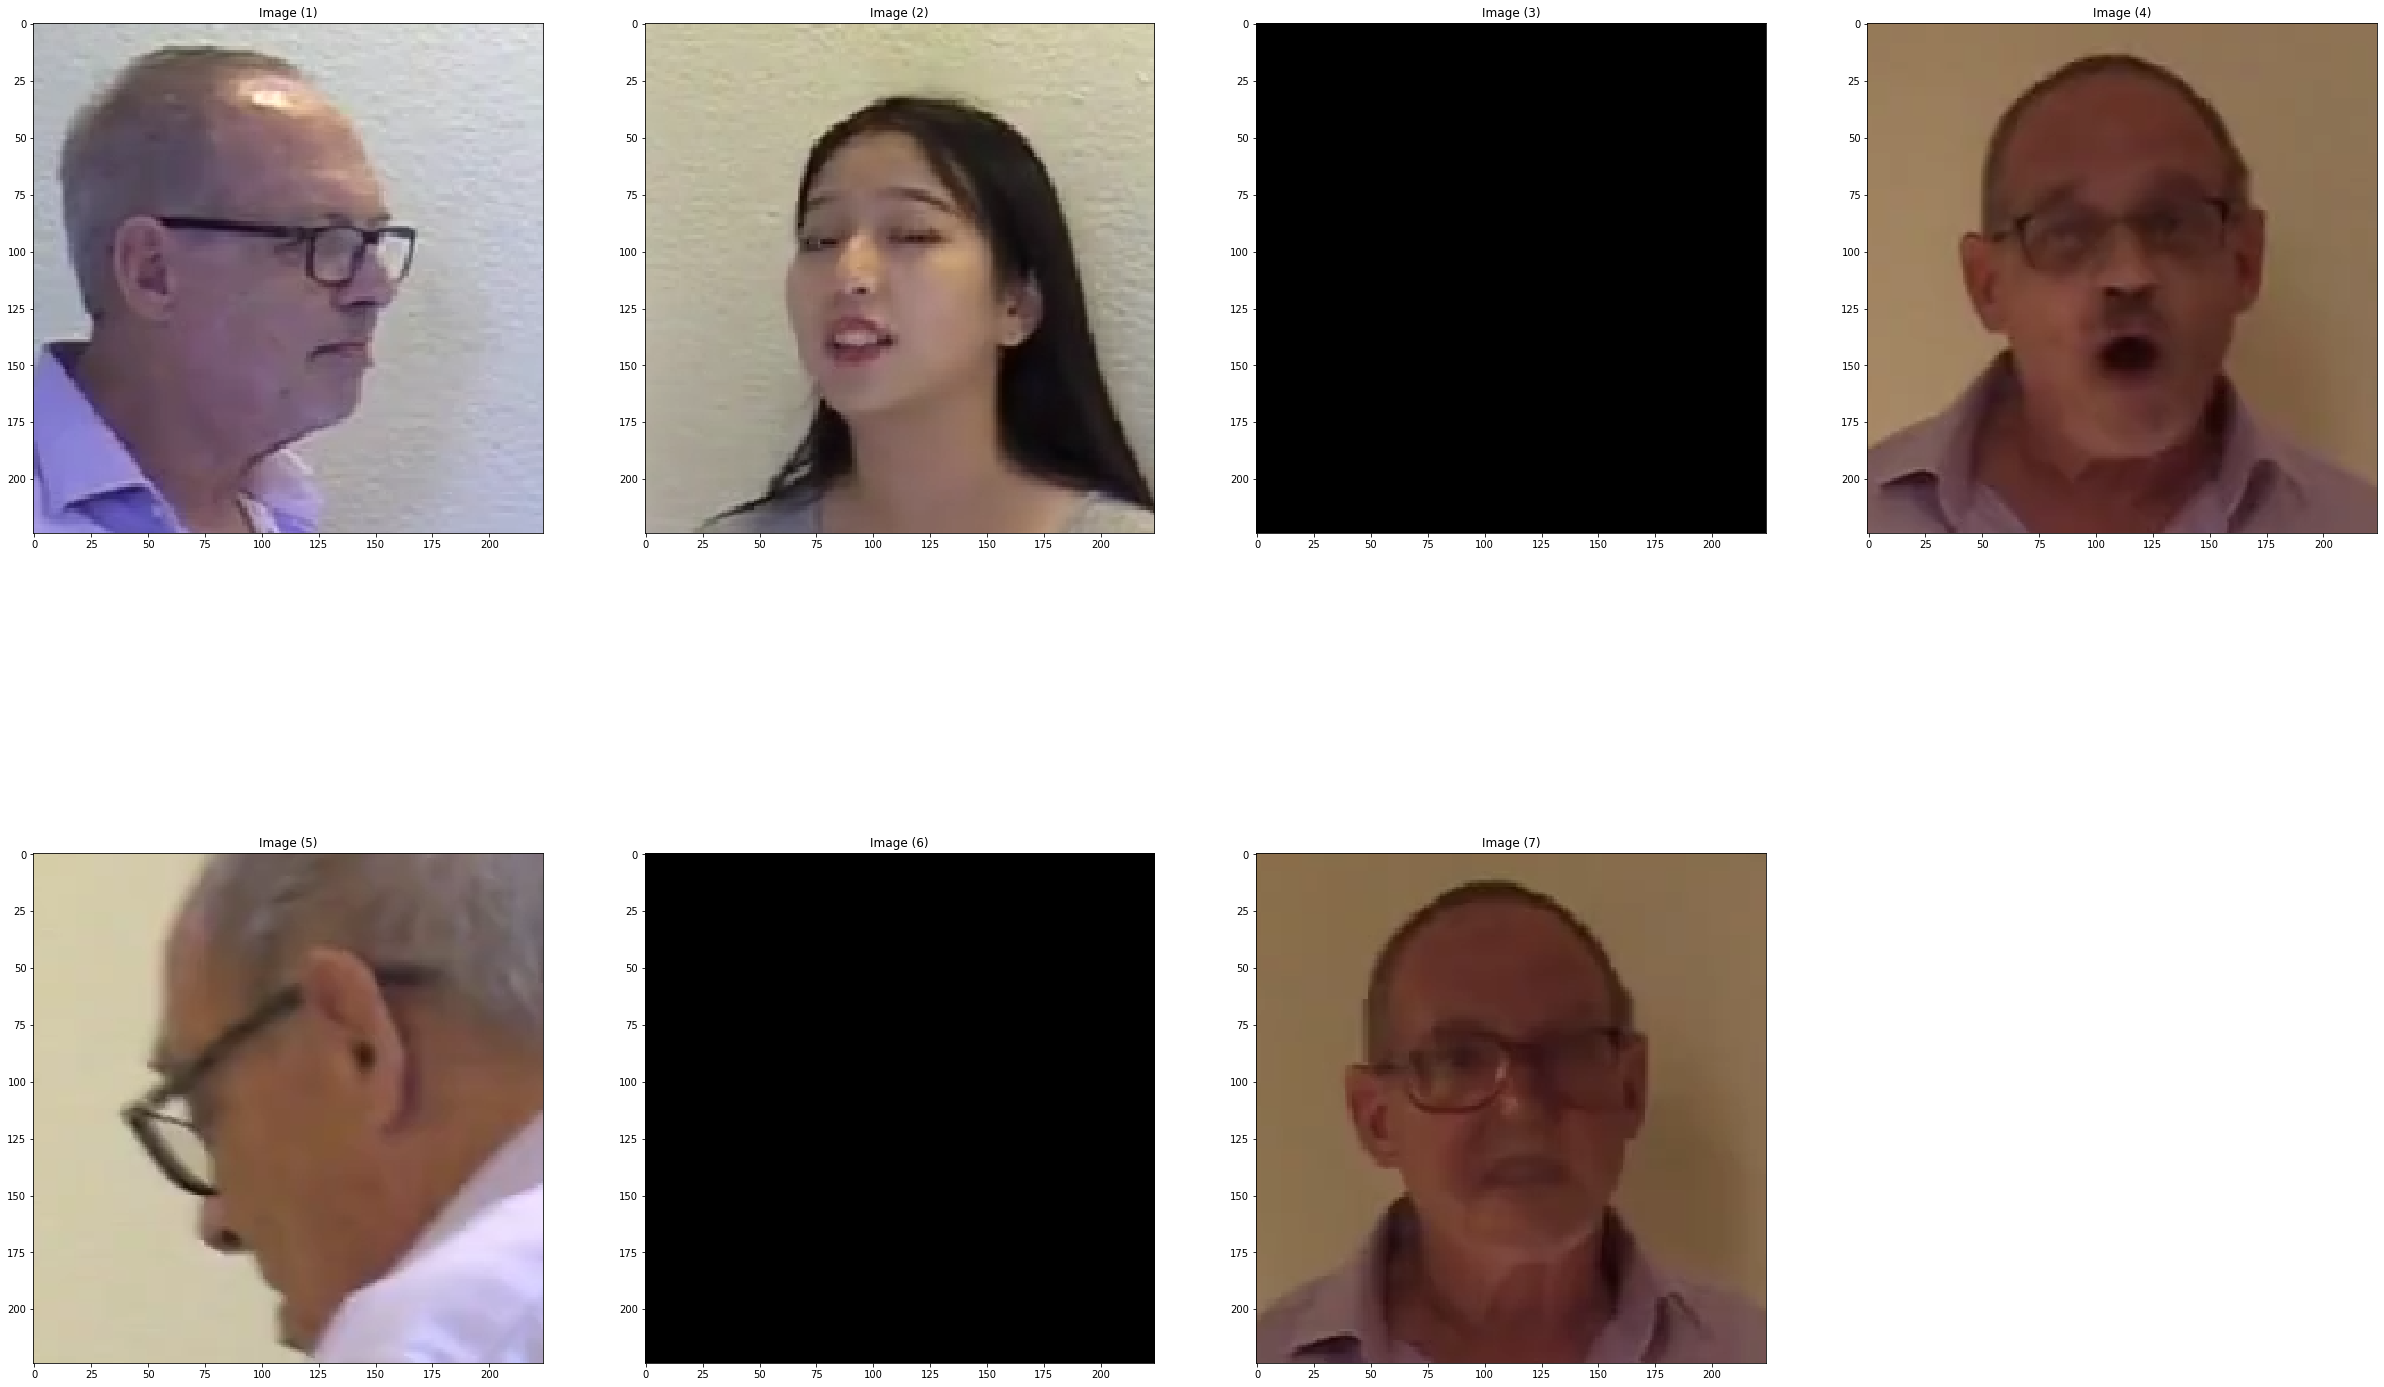

In [16]:
print(f'Frame: {i}')
sample = samples[:,i]
cols = math.ceil(len(sample)/4)
show_images(sample, cols=cols)
i += 1